In [ ]:
# =========================================================
# STEP 1: Upload the Excel file
# =========================================================
from google.colab import files
uploaded = files.upload()  # Upload 'Students_Performance.xlsx'

In [1]:
# =========================================================
# STEP 2: Read and view the Excel file
# =========================================================
import pandas as pd
df = pd.read_excel('Students_Performance.xlsx')
print("Data loaded successfully!")
print(df.head())

Data loaded successfully!
   gender Teaching_Method parental level of education         lunch  \
0  female         group B           bachelor's degree      standard   
1  female         group C                some college      standard   
2  female         group B             master's degree      standard   
3    male         group A          associate's degree  free/reduced   
4    male         group C                some college      standard   

  test preparation course  Math_Score  Reading_Score  Writing_Score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  


In [2]:
# =========================================================
# STEP 3: Install and import required libraries
# =========================================================
!pip install seaborn statsmodels bioinfokit

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from statsmodels.multivariate.manova import MANOVA
from bioinfokit.analys import stat


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for bioinfokit: filename=bioinfokit-2.1.4-py3-none-any.whl size=59317 sha256=eff2034ab4d08fbd06443e2bdb62e85040e7ca93be2aa7ae6237cc02b94a2337
  Stored in directory: c:\users\murilofarias\appdata\local\pip\cache\wheels\b4\76\43\7fa2c349dac62f041fe8d85c9f48e47ca25fc39fd79d0b5f5e
  Created wheel for matplotlib-venn: filename=matplotlib_venn-1.1.2-py3-none-any.whl size=45437 sha256=324d7afa90785802d4f19d6273beb0fdff4cb82ba8cbb8a64a5f67094e416eb6
  Stored in directory: c:\users\murilofarias\appdata\local\pip\cache\wheels\c2\47\0c\f014c55a1cfd56dce41a1

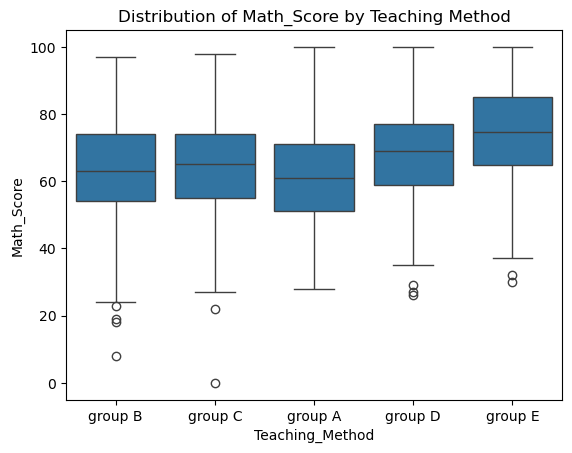

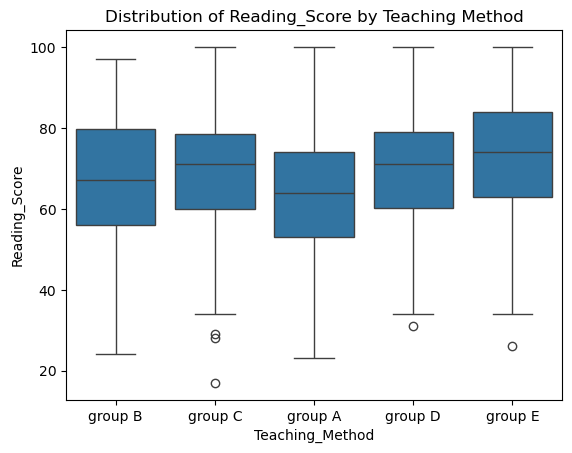

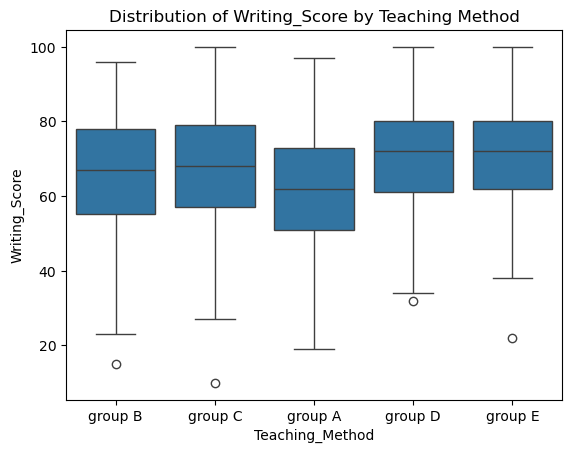

In [3]:
# =========================================================
# STEP 4: Visualize data using Seaborn
# =========================================================

# Boxplot for each dependent variable
for col in ['Math_Score','Reading_Score','Writing_Score']:
    sns.boxplot(x='Teaching_Method', y=col, data=df)
    plt.title(f'Distribution of {col} by Teaching Method')
    plt.show()

In [4]:
# =========================================================
# STEP 5: Split data into training and testing subsets
# =========================================================
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
print(f"Training data size: {len(train_df)} | Testing data size: {len(test_df)}")

Training data size: 700 | Testing data size: 300


In [5]:
# =========================================================
# STEP 6: CHECK ASSUMPTIONS OF MANOVA
# =========================================================
# 1- Multivariate normality (Shapiro-Wilk for each dependent variable per group)
from scipy.stats import shapiro

for dep in ['Math_Score','Reading_Score','Writing_Score']:
    print(f"\nShapiro-Wilk Test for {dep}:")
    for method in train_df['Teaching_Method'].unique():
        w, p = shapiro(train_df[train_df['Teaching_Method']==method][dep])
        print(f"{method}: W={w:.3f}, p={p:.3f}", end=" → ")
        if p > 0.05:
            print("Normal")
        else:
            print("Not normal")



Shapiro-Wilk Test for Math_Score:
group D: W=0.992, p=0.428 → Normal
group C: W=0.993, p=0.350 → Normal
group A: W=0.977, p=0.349 → Normal
group E: W=0.972, p=0.027 → Not normal
group B: W=0.977, p=0.029 → Not normal

Shapiro-Wilk Test for Reading_Score:
group D: W=0.990, p=0.220 → Normal
group C: W=0.990, p=0.131 → Normal
group A: W=0.979, p=0.409 → Normal
group E: W=0.981, p=0.143 → Normal
group B: W=0.986, p=0.207 → Normal

Shapiro-Wilk Test for Writing_Score:
group D: W=0.988, p=0.138 → Normal
group C: W=0.987, p=0.038 → Not normal
group A: W=0.978, p=0.385 → Normal
group E: W=0.979, p=0.089 → Normal
group B: W=0.984, p=0.145 → Normal


In [6]:
# 2- Homogeneity of covariance matrices (Box’s M test)

!pip install pingouin


In [7]:
import pingouin as pg

# Perform Box's M test
box_m_results = pg.box_m(data=df,
                         dvs=['Math_Score', 'Reading_Score', 'Writing_Score'],
                         group='Teaching_Method',
                         alpha=0.001)

# Display results
print(box_m_results)

          Chi2    df      pval  equal_cov
box  19.674658  24.0  0.715119       True


In [8]:
# =========================================================
# STEP 7: PERFORM MANOVA
# =========================================================
manova = MANOVA.from_formula('Math_Score + Reading_Score + Writing_Score ~ Teaching_Method', data=train_df)
print("\nMANOVA results:")
print(manova.mv_test())


MANOVA results:
                   Multivariate linear model
                                                               
---------------------------------------------------------------
        Intercept        Value  Num DF  Den DF  F Value  Pr > F
---------------------------------------------------------------
           Wilks' lambda 0.3364 3.0000 693.0000 455.7017 0.0000
          Pillai's trace 0.6636 3.0000 693.0000 455.7017 0.0000
  Hotelling-Lawley trace 1.9727 3.0000 693.0000 455.7017 0.0000
     Roy's greatest root 1.9727 3.0000 693.0000 455.7017 0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
    Teaching_Method     Value   Num DF   Den DF  F Value Pr > F
---------------------------------------------------------------
          Wilks' lambda 0.8992 12.0000 1833.7972  6.2602 0.0000
         Pillai's trace 0.1034 12.0000 208

In [9]:
# =========================================================
# STEP 8: TUKEY’S HSD TEST
# =========================================================
# Perform Tukey HSD for each dependent variable individually
from statsmodels.stats.multicomp import pairwise_tukeyhsd

for dep in ['Math_Score','Reading_Score','Writing_Score']:
    tukey = pairwise_tukeyhsd(endog=train_df[dep],
                              groups=train_df['Teaching_Method'],
                              alpha=0.05)
    print(f"\nTukey HSD results for {dep}:")
    print(tukey.summary())



Tukey HSD results for Math_Score:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
group A group B  -1.5977 0.9579 -7.8986  4.7031  False
group A group C     0.65 0.9982 -5.2262  6.5262  False
group A group D   2.8737 0.6879 -3.1465   8.894  False
group A group E   9.4561 0.0008  2.9196 15.9927   True
group B group C   2.2477  0.622 -2.1148  6.6102  False
group B group D   4.4714 0.0572 -0.0832  9.0261  False
group B group E  11.0538    0.0  5.8358 16.2719   True
group C group D   2.2237  0.536 -1.7226  6.1701  False
group C group E   8.8062    0.0  4.1097 13.5026   True
group D group E   6.5824 0.0022  1.7069 11.4579   True
------------------------------------------------------

Tukey HSD results for Reading_Score:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------